## Topic Modeling: Latent Semantic Analysis/Indexing

### Imports

In [22]:
import warnings
from collections import OrderedDict
from pathlib import Path
from random import randint
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

# sklearn for feature extraction & modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib

In [2]:
% matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14.0, 8.7)
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format

## Load BBC data

In [139]:
path = Path('bbc')
files = path.glob('**/*.txt')
doc_list = []
for i, file in enumerate(files):
    with open(str(file), encoding='latin1') as f:
        _, topic, file_name = file.parts

        lines = f.readlines()
        heading = lines[0].strip()
        body = ' '.join([l.strip() for l in lines[1:]])
        doc_list.append([topic.capitalize(), heading, body])

### Convert to DataFrame

In [140]:
docs = pd.DataFrame(doc_list, columns=['Category', 'Heading', 'Article'])
docs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 3 columns):
Category    2225 non-null object
Heading     2225 non-null object
Article     2225 non-null object
dtypes: object(3)
memory usage: 52.2+ KB


## Create Train & Test Sets

In [141]:
train_docs, test_docs = train_test_split(docs, 
                                         stratify=docs.Category, 
                                         test_size=50, 
                                         random_state=42)

In [142]:
train_docs.shape, test_docs.shape

((2175, 3), (50, 3))

In [145]:
pd.Series(test_docs.Category).value_counts()

Sport            12
Business         11
Entertainment     9
Tech              9
Politics          9
Name: Category, dtype: int64

### Vectorize train & test sets

In [147]:
vectorizer = TfidfVectorizer(max_df=.25, min_df=.01, stop_words='english', binary=False)
train_dtm = vectorizer.fit_transform(train_docs.Article)
train_dtm

<2175x2909 sparse matrix of type '<class 'numpy.float64'>'
	with 209745 stored elements in Compressed Sparse Row format>

In [148]:
test_dtm = vectorizer.transform(test_docs.Article)
test_dtm

<50x2909 sparse matrix of type '<class 'numpy.float64'>'
	with 4876 stored elements in Compressed Sparse Row format>

### Get token count

In [149]:
train_token_count = train_dtm.sum(0).A.squeeze()
tokens = vectorizer.get_feature_names()
word_count = pd.Series(train_token_count, index=tokens).sort_values(ascending=False)
word_count.head(10)

film         41.33
government   38.70
game         36.18
uk           35.99
best         35.93
labour       32.90
music        30.94
000          30.26
company      29.81
number       28.59
dtype: float64

## Latent Semantic Analysis

In [226]:
n_components = 5
topic_labels = ['Topic {}'.format(i) for i in range(1, n_components+1)]

In [153]:
svd = TruncatedSVD(n_components=n_components, 
                   n_iter=5, 
                   random_state=42)
svd.fit(train_dtm)

TruncatedSVD(algorithm='randomized', n_components=5, n_iter=5,
       random_state=42, tol=0.0)

In [154]:
svd.singular_values_

array([8.92087786, 5.7345608 , 5.40534764, 5.05164377, 4.73209665])

In [155]:
svd.explained_variance_ratio_

array([0.00187013, 0.01559657, 0.01389949, 0.01215811, 0.01066395])

### Explore Topics 

In [228]:
train_doc_topics = svd.transform(train_dtm)

In [229]:
train_doc_topics.shape

(2175, 5)

#### Topic Weights for sample article

In [230]:
i = randint(0, len(train_docs))
(train_docs.iloc[i, :2].append(pd.Series(train_doc_topics[i], 
                                         index=topic_labels)))

Category                          Tech
Heading     Mobile gig aims to rock 3G
Topic 1                           0.20
Topic 2                          -0.05
Topic 3                          -0.19
Topic 4                           0.00
Topic 5                           0.26
dtype: object

#### Average topic weight per category

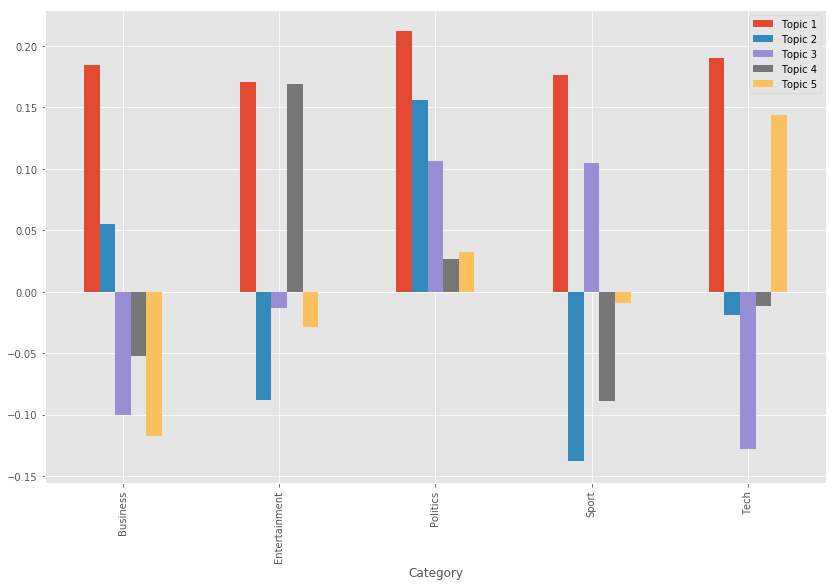

In [170]:
train_result = pd.DataFrame(data=doc_topics,
                   columns=topic_labels,
                   index=train_docs.Category)
train_result.groupby(level='Category').mean().plot.bar();

#### Topics weights of most frequent words

In [108]:
topics = pd.DataFrame(svd.components_.T,
                      index=tokens,
                      columns=topic_labels)
topics.loc[word_count.head(10).index]

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
film,0.10,-0.15,-0.02,0.46,-0.11
government,0.11,0.16,0.04,-0.00,-0.03
game,0.09,-0.16,0.08,-0.11,0.06
uk,0.09,0.03,-0.06,0.04,0.02
best,0.09,-0.14,0.03,0.27,-0.09
labour,0.10,0.25,0.21,0.07,0.06
music,0.08,-0.06,-0.11,0.08,0.14
000,0.07,0.03,-0.05,0.00,-0.01
company,0.07,0.02,-0.10,-0.03,-0.06
number,0.07,-0.04,-0.02,0.03,0.01


#### Most important words by topic

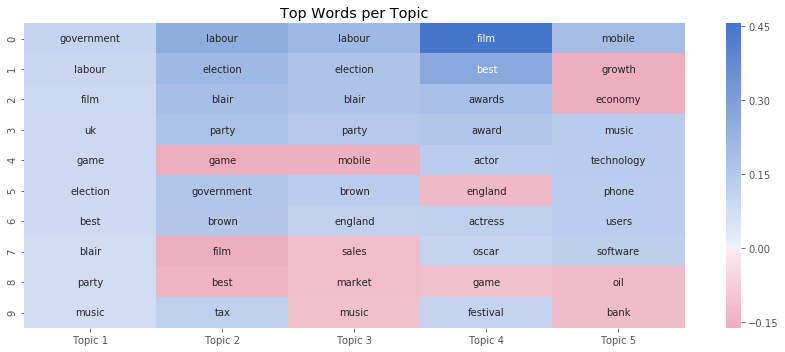

In [225]:
fig, ax = plt.subplots(figsize=(12,5))
top_words, top_vals = pd.DataFrame(), pd.DataFrame()
for topic, words_ in topics.items():
    top10 = words_.abs().nlargest(10).index
    vals = words_.loc[top10].values
    top_vals[topic] = vals
    top_words[topic] = top10.tolist()
sns.heatmap(pd.DataFrame(top_vals), 
            annot=top_words, 
            fmt = '', 
            center=0, 
            cmap=sns.diverging_palette(0, 255, sep=1, n=256), 
            ax=ax);
ax.set_title('Top Words per Topic')
fig.tight_layout()
fig.savefig('lsa_top_words', dpi=300);

#### Topics weights for test set

In [168]:
test_eval = pd.DataFrame(data=svd.transform(test_dtm), 
                         columns=topic_labels,
                         index=test_docs.Category)

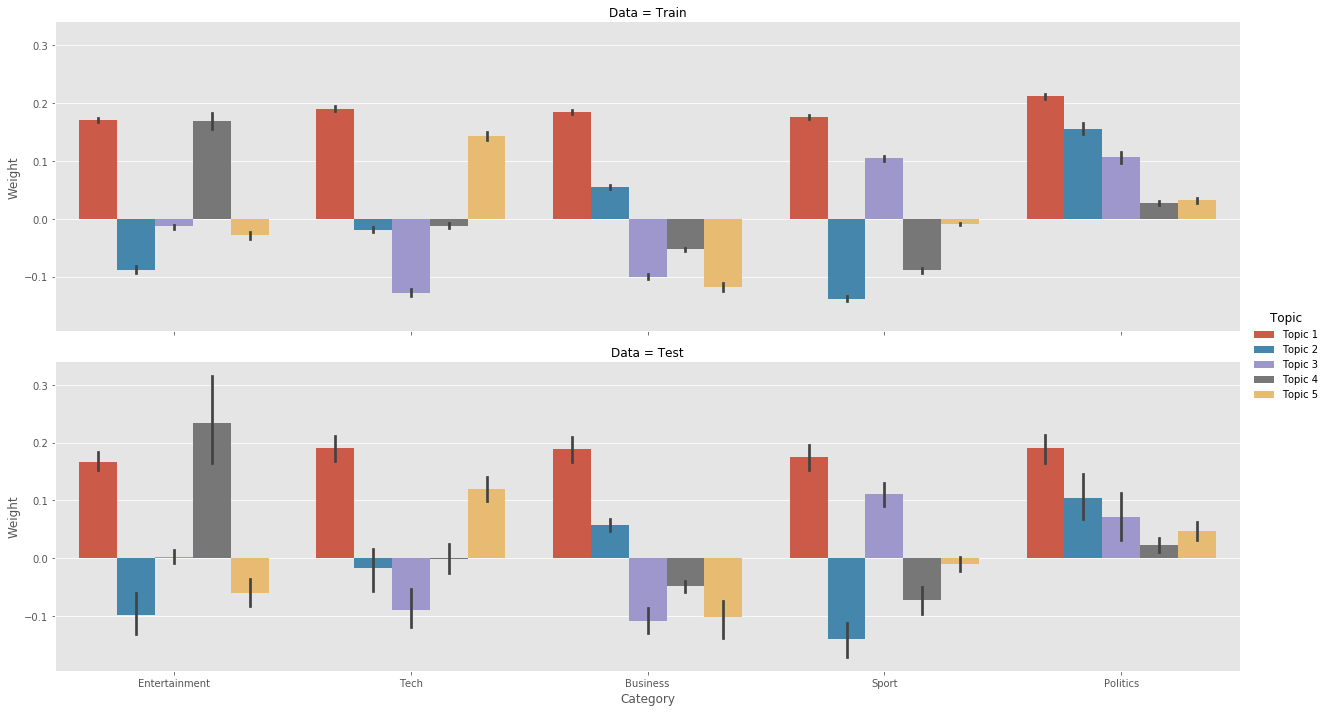

In [198]:
result = pd.melt(train_result.assign(Data='Train')
                 .append(test_eval.assign(Data='Test'))
                 .reset_index(),
                 id_vars=['Data', 'Category'],
                 var_name='Topic',
                 value_name='Weight')

g =sns.catplot(x='Category', y='Weight', hue='Topic', row='Data', kind='bar', data=result, aspect=3.5)
g.savefig('lsa_train_test', dpi=300)

### Categories in 2D

In [212]:
pca = PCA(n_components=2)
svd2d = pd.DataFrame(pca.fit_transform(train_result), columns=['PC1', 'PC2']).assign(Category=train_docs.Category)
categories_2d = svd2d.groupby('Category').mean()

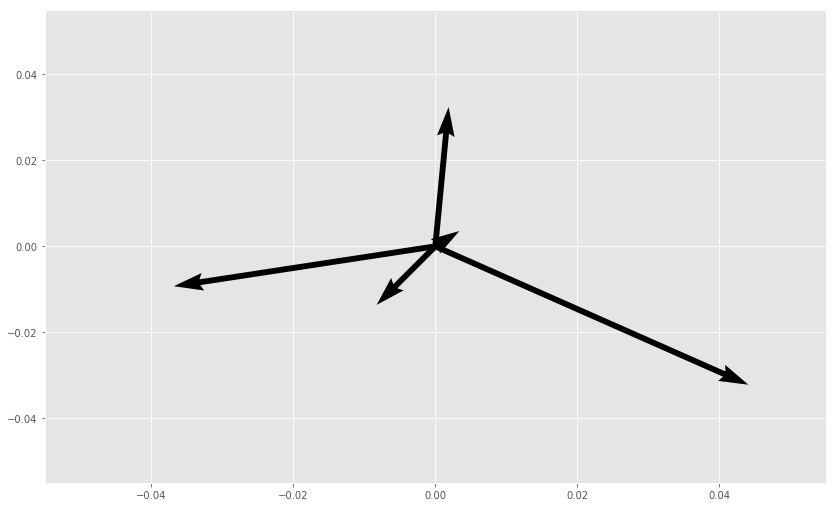

In [224]:
plt.quiver(*([0], [0]), categories_2d.PC1, categories_2d.PC2, scale=.03);